# Examine EQUIX Chameleon data

I'm confused by disagreements between heat flux calculated from χ or ε.

TODO: 

1. [x] calculate gradients using sorted profiles; this bumps up Jq by a factor of 2!
    - Sasha's dTdz is calculated using θ sorted by θ, and N2 is calculated using σ sorted by σ
    - Sasha's χpod N2 = gα dTdz with α calculated using S=34
1. Seems very sensitive to low gradient locations
1. Figure out what level to filter χ, ε at: 1e-2? 1e-5 in jims multiprofv2.m
1. Add values for sensor 1, sensor2 to χpod datasets
1. Add Jq_ε for χpods
1. Try with TH or TIWE

In [ ]:
%load_ext watermark
%matplotlib inline


import glob
import os

import cf_xarray as cfxr
import dcpy
import distributed
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dcpy.oceans import read_osu_microstructure_mat, thorpesort
from IPython.display import Image

# import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

%watermark -iv

In [ ]:
def Jq(x, *, min_dTdz):

    return (
        (
            1025
            * 4000
            * x.chi.where(x.chi < 2e-2)
            / 2
            / x.dTdz.where(np.abs(x.dTdz) > min_dTdz)
        )
        .rolling(depth=5, center=True)
        .mean()
    )

In [ ]:
read_osu_microstructure_mat(os.path.expanduser("/Users/dcherian/datasets/microstructure/osu/eq08_sum_deglitched.mat"))

In [110]:
cham = xr.load_dataset(os.path.expanduser("~/datasets/microstructure/osu/equix.nc"))

theta_old = cham.theta.copy(deep=True)
cham["depth"] = cham.depth.astype(float)
cham["sortTbyT"] = thorpesort(cham.theta, cham.theta, ascending=False)
cham["sortT"] = thorpesort(cham.theta, cham.pden, ascending=True)
cham["NT2"] = (
    -9.81
    * dcpy.eos.alpha(
        34 * xr.ones_like(cham.theta), cham.theta, cham.pres.broadcast_like(cham.theta)
    )
    * cham.dTdz
)

chamρ = cham.copy(deep=True)
chamρ["dTdz"] = chamρ.sortT.diff("depth", label="lower")

chamT = cham.copy(deep=True)
chamT["dTdz"] = chamT.sortTbyT.diff("depth", label="lower")

cham

<xarray.Dataset>
Dimensions:          (depth: 200, time: 2624, zeuc: 80)
Coordinates:
  * depth            (depth) float64 1.0 2.0 3.0 4.0 ... 197.0 198.0 199.0 200.0
    lon              (time) float64 -139.9 -139.9 -139.9 ... -139.9 -139.9
    lat              (time) float64 0.06246 0.0622 0.06263 ... 0.06317 0.06341
  * time             (time) datetime64[ns] 2008-10-24T20:36:23 ... 2008-11-08...
  * zeuc             (zeuc) float64 -200.0 -195.0 -190.0 ... 185.0 190.0 195.0
Data variables: (12/48)
    pmax             (time) float64 205.9 199.0 202.0 ... 202.0 221.1 203.9
    castnumber       (time) uint16 16 17 18 19 20 ... 2664 2665 2666 2667 2668
    AX_TILT          (depth, time) float64 9.642 -48.16 nan ... 4.232 1.28
    AY_TILT          (depth, time) float64 14.52 11.51 nan ... -2.121 0.05032
    AZ2              (depth, time) float64 0.04277 1.537e-05 ... 3.208e-06
    C                (depth, time) float64 5.244 5.291 nan ... 4.135 4.137 4.164
    ...               ...
    count_Jq_euc     (time, zeuc) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    count_dJdz_euc   (time, zeuc) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    count_dTdt_euc   (time, zeuc) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    count_u_euc      (time, zeuc) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    count_depth_euc  (time, zeuc) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    NT2              (depth, time) float64 nan nan nan ... 0.0001089 0.000102
Attributes:
    starttime:  ['Time:20:34:29 298   ' 'Time:20:42:18 298   ' 'Time:20:52:14...
    endtime:    ['Time:20:38:29 298   ' 'Time:20:46:29 298   ' 'Time:20:56:29...

There are some masks applied in XXX.m, I think the dataset I have has those masks applied.

In [ ]:
# badmask = (cham.VARAZ > 0.01) & (np.log10(cham.AZ2) > -4.5) & (cham.eps > 1e-4)
# cham = cham.where(~badmask)

In [111]:
tao = xr.open_dataset(
    os.path.expanduser("~/work/datasets/microstructure/osu/equix/hourly_tao.nc")
)
iop = xr.open_dataset(
    os.path.expanduser("~/datasets/microstructure/osu/equix/hourly_iop.nc")
)
eop = xr.open_dataset(
    os.path.expanduser("~/datasets/microstructure/osu/equix/hourly_eop.nc")
)
tao_iop = xr.open_dataset(
    os.path.expanduser("~/datasets/microstructure/osu/equix/hourly_tao_iop.nc")
)

for suffix in ["1", "2"]:
    tao_iop["NT2" + suffix] = (
        9.81
        * dcpy.eos.alpha(
            34 * np.ones_like(tao_iop["T1"]),
            tao_iop["T" + suffix],
            tao_iop.depth.broadcast_like(tao_iop.T1),
        )
        * tao_iop[f"dT{suffix}dz"]
    )

iop["NT2"] = (
    9.81 * dcpy.eos.alpha(34 * xr.ones_like(iop.theta), iop.theta, iop.depth) * iop.dTdz
)

Tbins = np.hstack(
    [np.arange(18, 22, 1), np.arange(22, 25, 0.5), np.arange(25, 26.1, 0.25)]
)

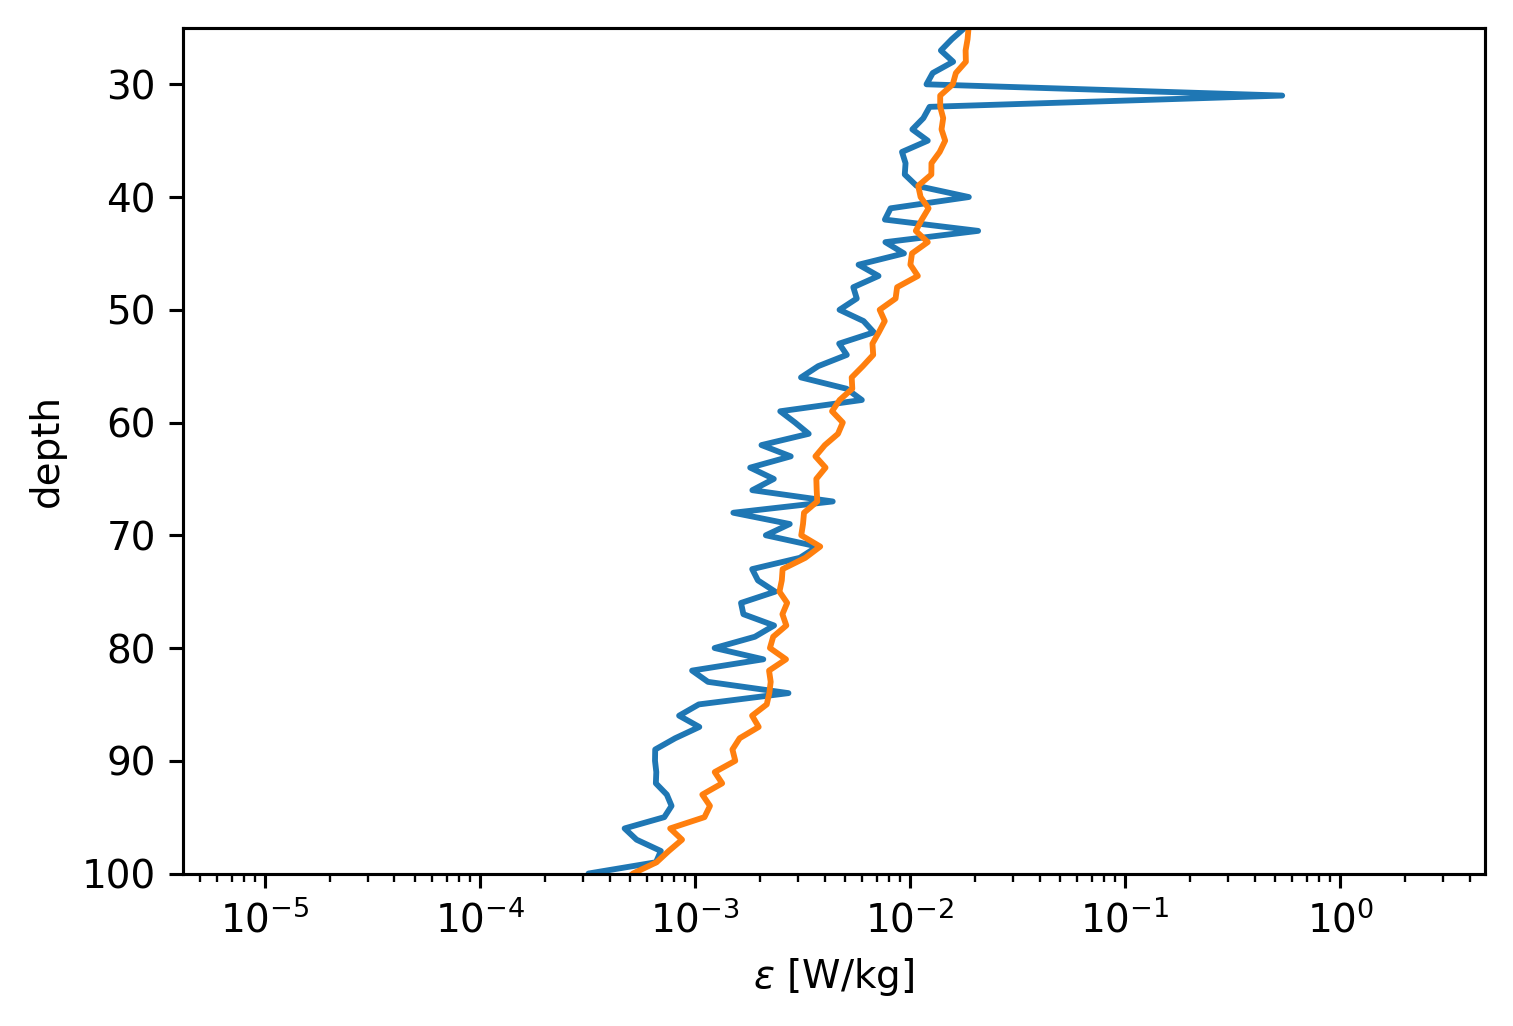

In [112]:
mask = np.ones_like(cham.dTdz, dtype=bool)
# mask = (np.abs(cham.dTdz) > 1e-3) & (cham.N2 > 1e-5)
(cham.chi / 2 / cham.dTdz.where(mask) ** 2).mean("time").plot(
    y="depth", xscale="log", yincrease=False
)
(0.2 * cham.eps / cham.N2.where(mask)).mean("time").plot(
    y="depth", xscale="log", yincrease=False, ylim=(100, 25)
)

## Test thorpe sorting

In [ ]:
import pandas as pd

time = pd.Timestamp("2008-11-03 04:00:00")

profile = cham.sel(time=[time], method="nearest")
profile.theta.plot(hue="time")
thorpesort(profile.theta, profile.theta, ascending=False).plot(hue="time", marker=".")
thorpesort(profile.theta, profile.pden, ascending=True).plot(hue="time", marker="x")

In [ ]:
time = pd.Timestamp("2008-11-03 04:00:00")

theta_old.sel(time=time, method="nearest").plot()
theta_old.sel(time=time, method="nearest").plot(color="k", marker=".")
cham.theta.sel(time=time, method="nearest").plot(color="blue", marker="^")
cham.sortT.sel(time=time, method="nearest").plot()
cham.sortTbyT.sel(time=time, method="nearest").plot(color="r")

## Sorting and calculating gradients


1. Trying to replicate Sasha's dT/dz
1. Sasha's dT/dz looks like he's sorted $T$ by $T$, instead of $ρ$, but I still have trouble replicating. Note he has no negative values.


`cali_eq08.m` is useful. `SIGMA_ORDER` and `THETA_ORDER` are thorpesorted by `calc_order`
``` matlab
% calculate SIGMA_ORDER
inds=calc_order('sigma','P');
% calculate THETA_ORDER
inds=calc_order('theta','P');

% calculate the mean temperature gradient on small scales:
cal.DTDZ=diff(cal.THETA_ORDER)./diff(cal.P);
cal.DTDZ(length(cal.DTDZ)+1)=cal.DTDZ(length(cal.DTDZ));
head.irep.DTDZ=1;

% calculate the mean density gradient on small scales:
cal.DRHODZ=diff(cal.SIGMA_ORDER)./diff(cal.P);
cal.DRHODZ(length(cal.DRHODZ)+1)=cal.DRHODZ(length(cal.DRHODZ));
head.irep.DRHODZ=1;
g=9.81;
cal.SIGMA=cal.SIGMA-1000;
cal.SIGMA_ORDER=cal.SIGMA_ORDER-1000;
rhoav=mean(cal.SIGMA(1:1:length(cal.SIGMA)-1))+1000;

cal.N2=(g/rhoav).*diff(cal.SIGMA_ORDER)./diff(cal.P);
cal.N2(length(cal.N2)+1)=cal.N2(length(cal.N2));
```

This confirms that `THETA` is sorted by `THETA` and `SIGMA` by `SIGMA`. A simple `diff` is used and the last value is repeated at the end.

Some deglitching of N2 happens in `sum_eq08.m`

In [ ]:
rhoav = cham.pden.mean().data + 1000
rhoav

In [ ]:
profile = cham.isel(time=200)
# 1m spacing so a simple diff is the gradient...
profile.theta.diff("depth", label="lower").plot(aspect=4, size=5, label="dtheta/dz")
profile.sortT.diff("depth", label="lower").plot(label="d/dz sorted by ρ")
profile.sortTbyT.diff("depth", label="lower").plot(label="d/dz sorted by T")
# cham5m.T.isel(time=150).diff("depth").plot()
profile.dTdz.plot(color="k", label="Sasha")
dcpy.plots.liney(0)
plt.legend()

In [ ]:
profile = cham.isel(time=200)
# 1m spacing so a simple diff is the gradient...
profile.pden.diff("depth", label="lower").plot(aspect=4, size=5, label="dpden/dz")
thorpesort(profile.pden, profile.pden).diff("depth", label="lower").plot(label="d/dz sorted by ρ")
# cham5m.T.isel(time=150).diff("depth").plot()
profile.DRHODZ.plot(color="k", label="Sasha")
dcpy.plots.liney(0)
plt.legend()

In [ ]:
for da in [
    cham.N2,
    (9.81 / 1025 * cham.pden.diff("depth")),
    (9.81 / 1025 * thorpesort(cham.pden, cham.pden).diff("depth")),
]:
    da.plot.hist(
        yscale="linear", bins=np.logspace(-8, -1, 100), xscale="log", histtype="step"
    )

plt.legend(["sasha", "pden", "pden sorted"])

In [ ]:
cham.T.diff("depth").mean("time").plot()
cham.sortT.diff("depth").mean("time").plot()
cham.sortTbyT.diff("depth").mean("time").plot()

## Different Jq calculations

In [ ]:
f, ax = plt.subplots(1, 3)
f.set_size_inches((12, 3))
cham5m = cham

cham.dTdz.sel(depth=slice(125)).mean("time").cf.plot(ax=ax[0])
cham5m.sortT.diff("depth").sel(depth=slice(125)).mean("time").cf.plot(ax=ax[0])
cham5m.sortTbyT.diff("depth").sel(depth=slice(125)).mean("time").cf.plot(ax=ax[0])

ax[0].set_xlabel("$∂T/∂z$")

_, bins, _ = cham.dTdz.sel(depth=slice(125)).plot.hist(
    histtype="step", bins=np.linspace(-0.1, 0.1, 1000), ax=ax[1], label="Sasha"
)
cham5m.sortT.diff("depth").sel(depth=slice(125)).plot.hist(
    histtype="step", bins=bins, yscale="log", ax=ax[1], label="T sorted by ρ"
)
cham5m.sortTbyT.diff("depth").sel(depth=slice(125)).plot.hist(
    histtype="step",
    bins=bins,
    yscale="log",
    ax=ax[1],
    label="T sorted by T",
)
ax[1].set_xlabel("$∂T/∂z$")


def Jq_(x, Tname):
    dTdz = x[Tname].differentiate("depth")
    return 1025 * 4000 * x.chi.where(x.chi < 1e-2) / 2 / dTdz


_, bins, _ = (
    Jq_(cham, "T")
    .sel(depth=slice(125))
    .plot.hist(
        histtype="step", bins=np.linspace(-0.1, 0.1, 1000), ax=ax[2], label="Sasha"
    )
)
Jq_(cham, "sortT").sel(depth=slice(125)).plot.hist(
    histtype="step", bins=bins, yscale="log", ax=ax[2], label="T sorted by ρ"
)
Jq_(cham, "sortTbyT").sel(depth=slice(125)).plot.hist(
    histtype="step",
    bins=bins,
    yscale="log",
    ax=ax[2],
    label="T sorted by T",
)

ax[-1].set_xlabel("$J_q^χ$")
ax[-1].legend(bbox_to_anchor=(1.0, 0.5))

In [ ]:
profile = cham.isel(time=200)
# profile.N2.plot()
(profile.DRHODZ).plot()
(thorpesort(profile.pden, profile.pden).diff("depth")).plot()

In [ ]:
def plot(c, name):
    j = Jq(c, min_dTdz=1e-3)
    hdl = j.where(j < 0).mean("time").plot(y="depth", label=name)
    j.where(j > 0).mean("time").plot(
        color=hdl[0].get_color(), y="depth", yincrease=False
    )
    j.mean("time").plot(
        marker=".", color=hdl[0].get_color(), y="depth", yincrease=False
    )


plot(chamρ, "sorted by ρ")
plot(chamT, "sorted by T")
plt.legend()
plt.xlabel("$J_q^χ$")

## $J_q^ε$ vs $J_q^χ$

\begin{align*}
J_q^χ &= ρ c_p K_T T_z = ρ c_p \frac{χ/2}{T_z^2} T_z \\
J_q^ε &= ρ c_p K_ρ T_z = ρ c_p \frac{Γε}{N²} T_z
\end{align*}

In [ ]:
#xr.set_options(use_numpy_groupies=False)
#cham_legacy = pump.tspace.regrid_chameleon(
    # These thresholds make a big difference! but really it's a very small number of points
#    cham.where((cham.chi < 1e-2) & (cham.eps < 1e-5))
#    .sel(depth=slice(156))
#    .where(cham.depth > cham.mld + 5)
#    .isel(time=slice(24 * 6)),
#    time_freq="3H",
#    bins=bins,
#    trim_mld=False,
#)

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True)
cham_legacy.chi.mean("time").plot(ax=ax[0], y="theta_c")
cham_npg.chi.mean("time").plot(ax=ax[0], y="theta_c")

(cham_legacy.nobs-cham_npg.nobs).plot(ax=ax[1], y="theta_bins", cmap=mpl.cm.Reds)

In [20]:
# xr.set_options(use_flox=True)
cham_npg = pump.tspace.regrid_chameleon(
    # These thresholds make a big difference! but really it's a very small number of points
    cham.where((cham.chi < 1e-2))
    .sel(depth=slice(156))
    .where(cham.depth > cham.mld + 5),
    # .isel(time=slice(24 * 6)),
    time_freq="3H",
    bins=Tbins,
    trim_mld=False,
)

In [21]:
cham_Tspace = cham_npg
cham_Tmean = cham_Tspace.mean("time")
cham_Tmean.coords["z_c"] = cham_Tspace.z_c.mean("time")

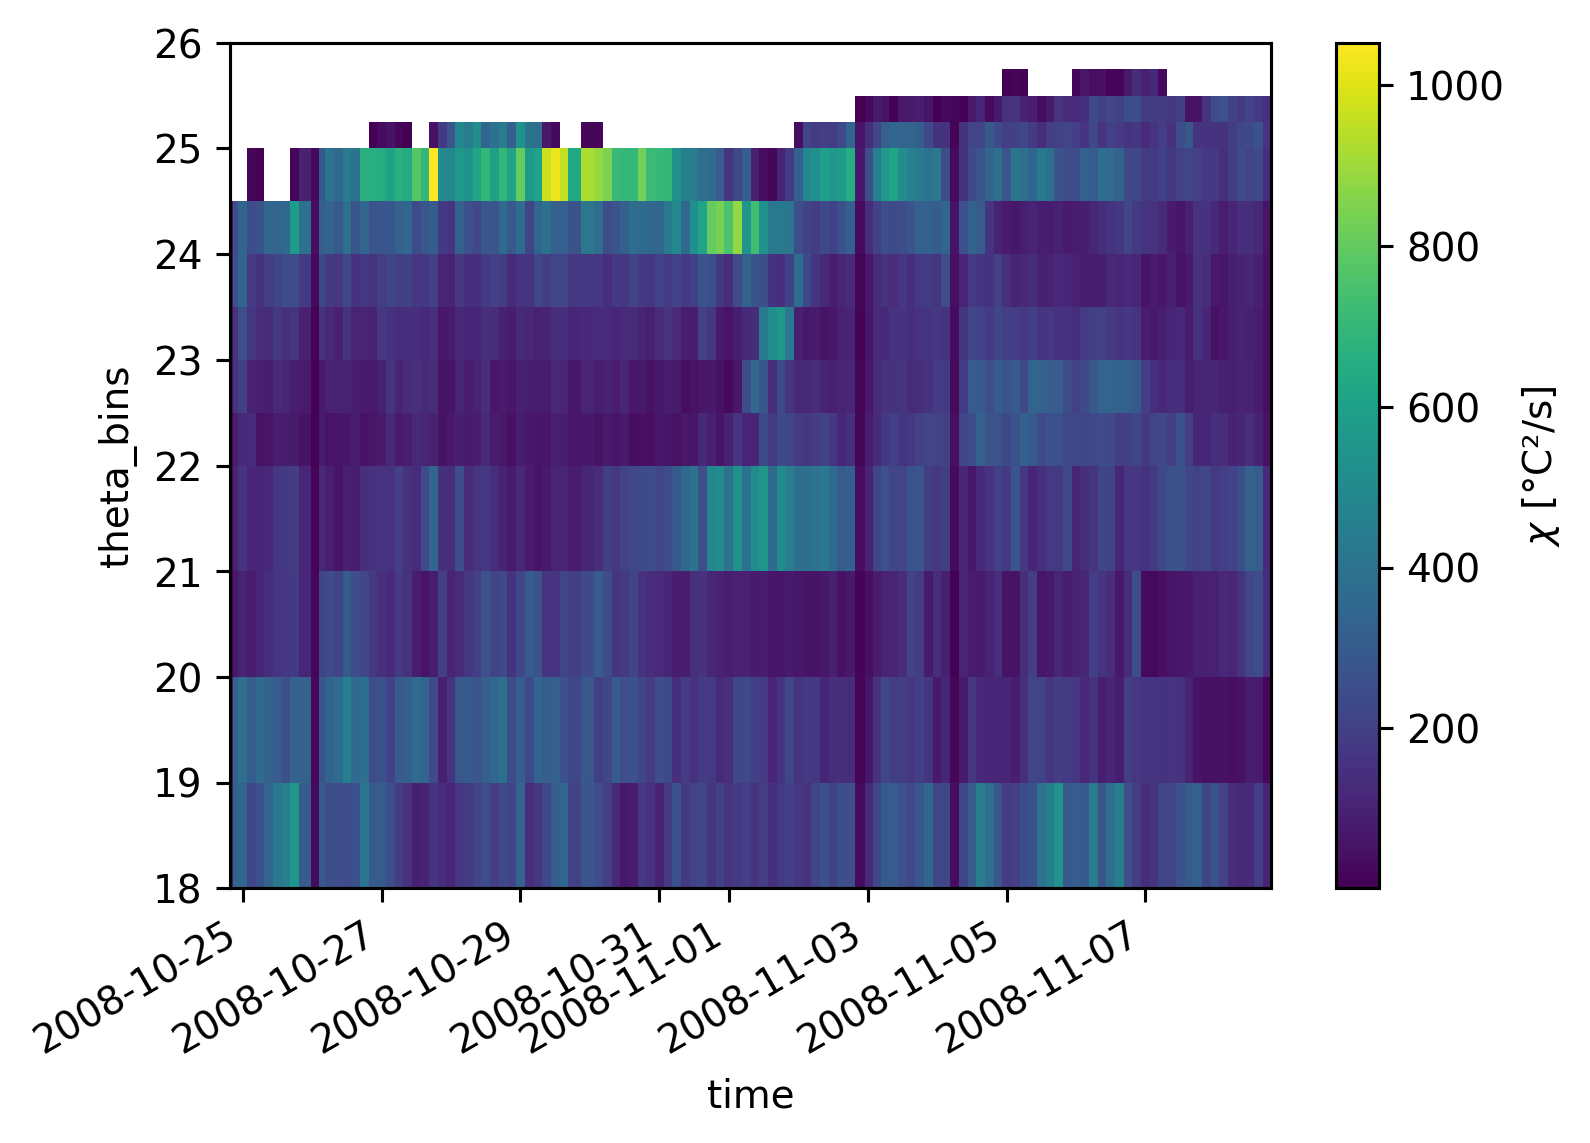

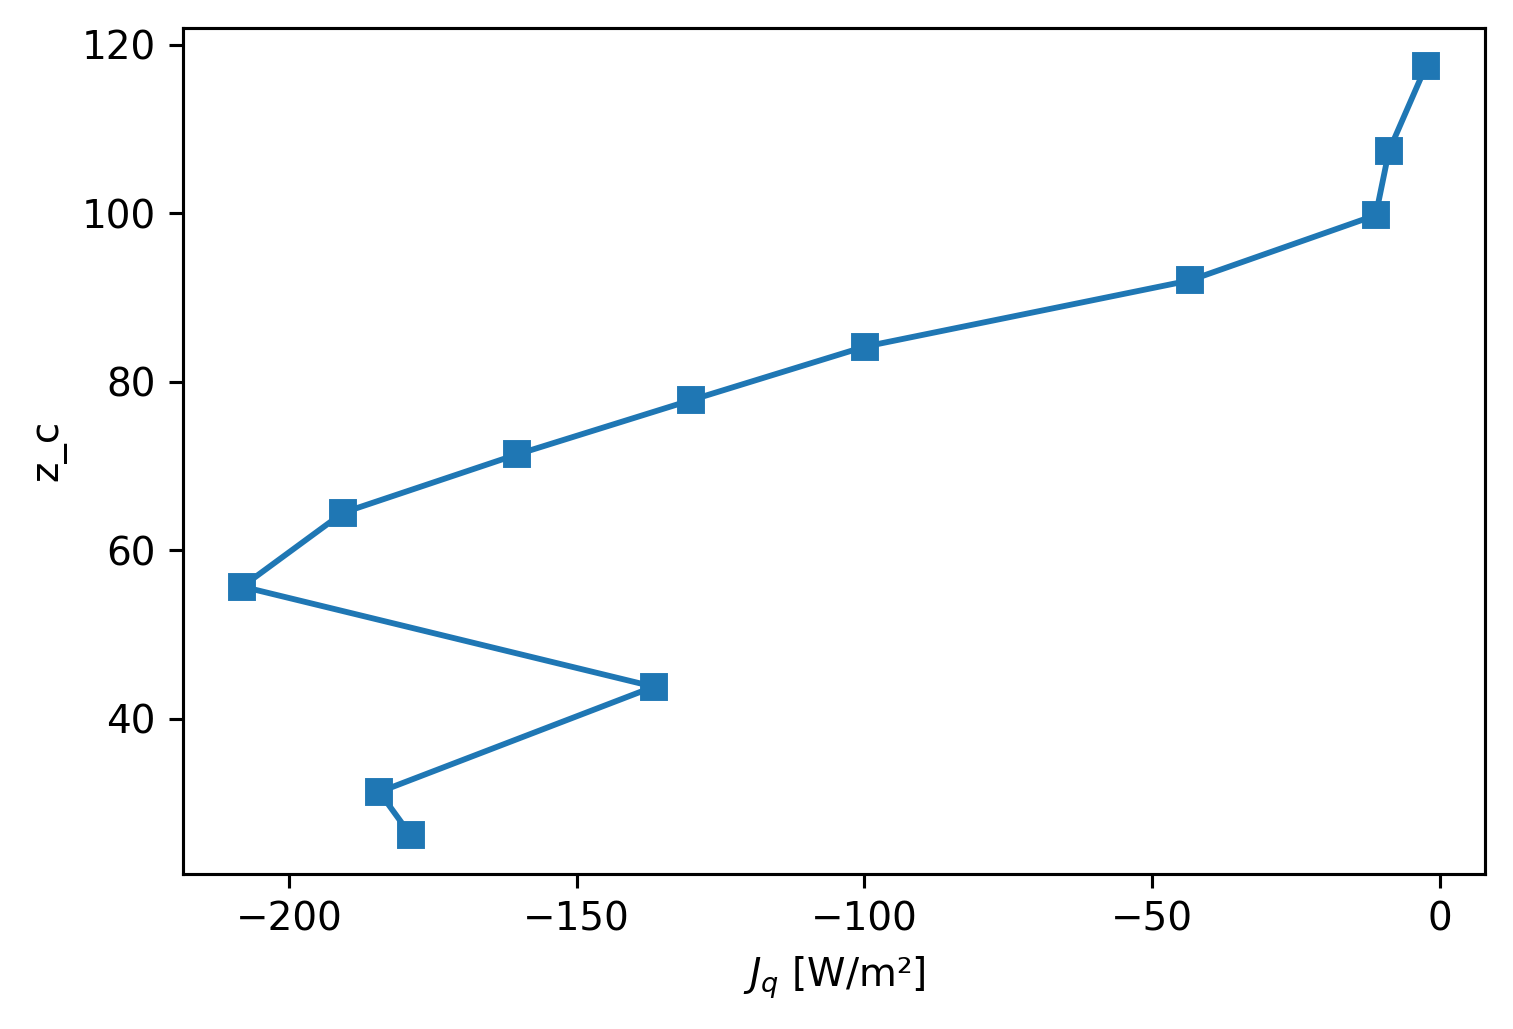

In [22]:
%matplotlib inline
mpl.rcParams["figure.dpi"] = 140

cham_Tspace.nobs.plot(x="time")
plt.figure()
cham_Tmean.Jq.plot(y="z_c", marker="s", yincrease=True)

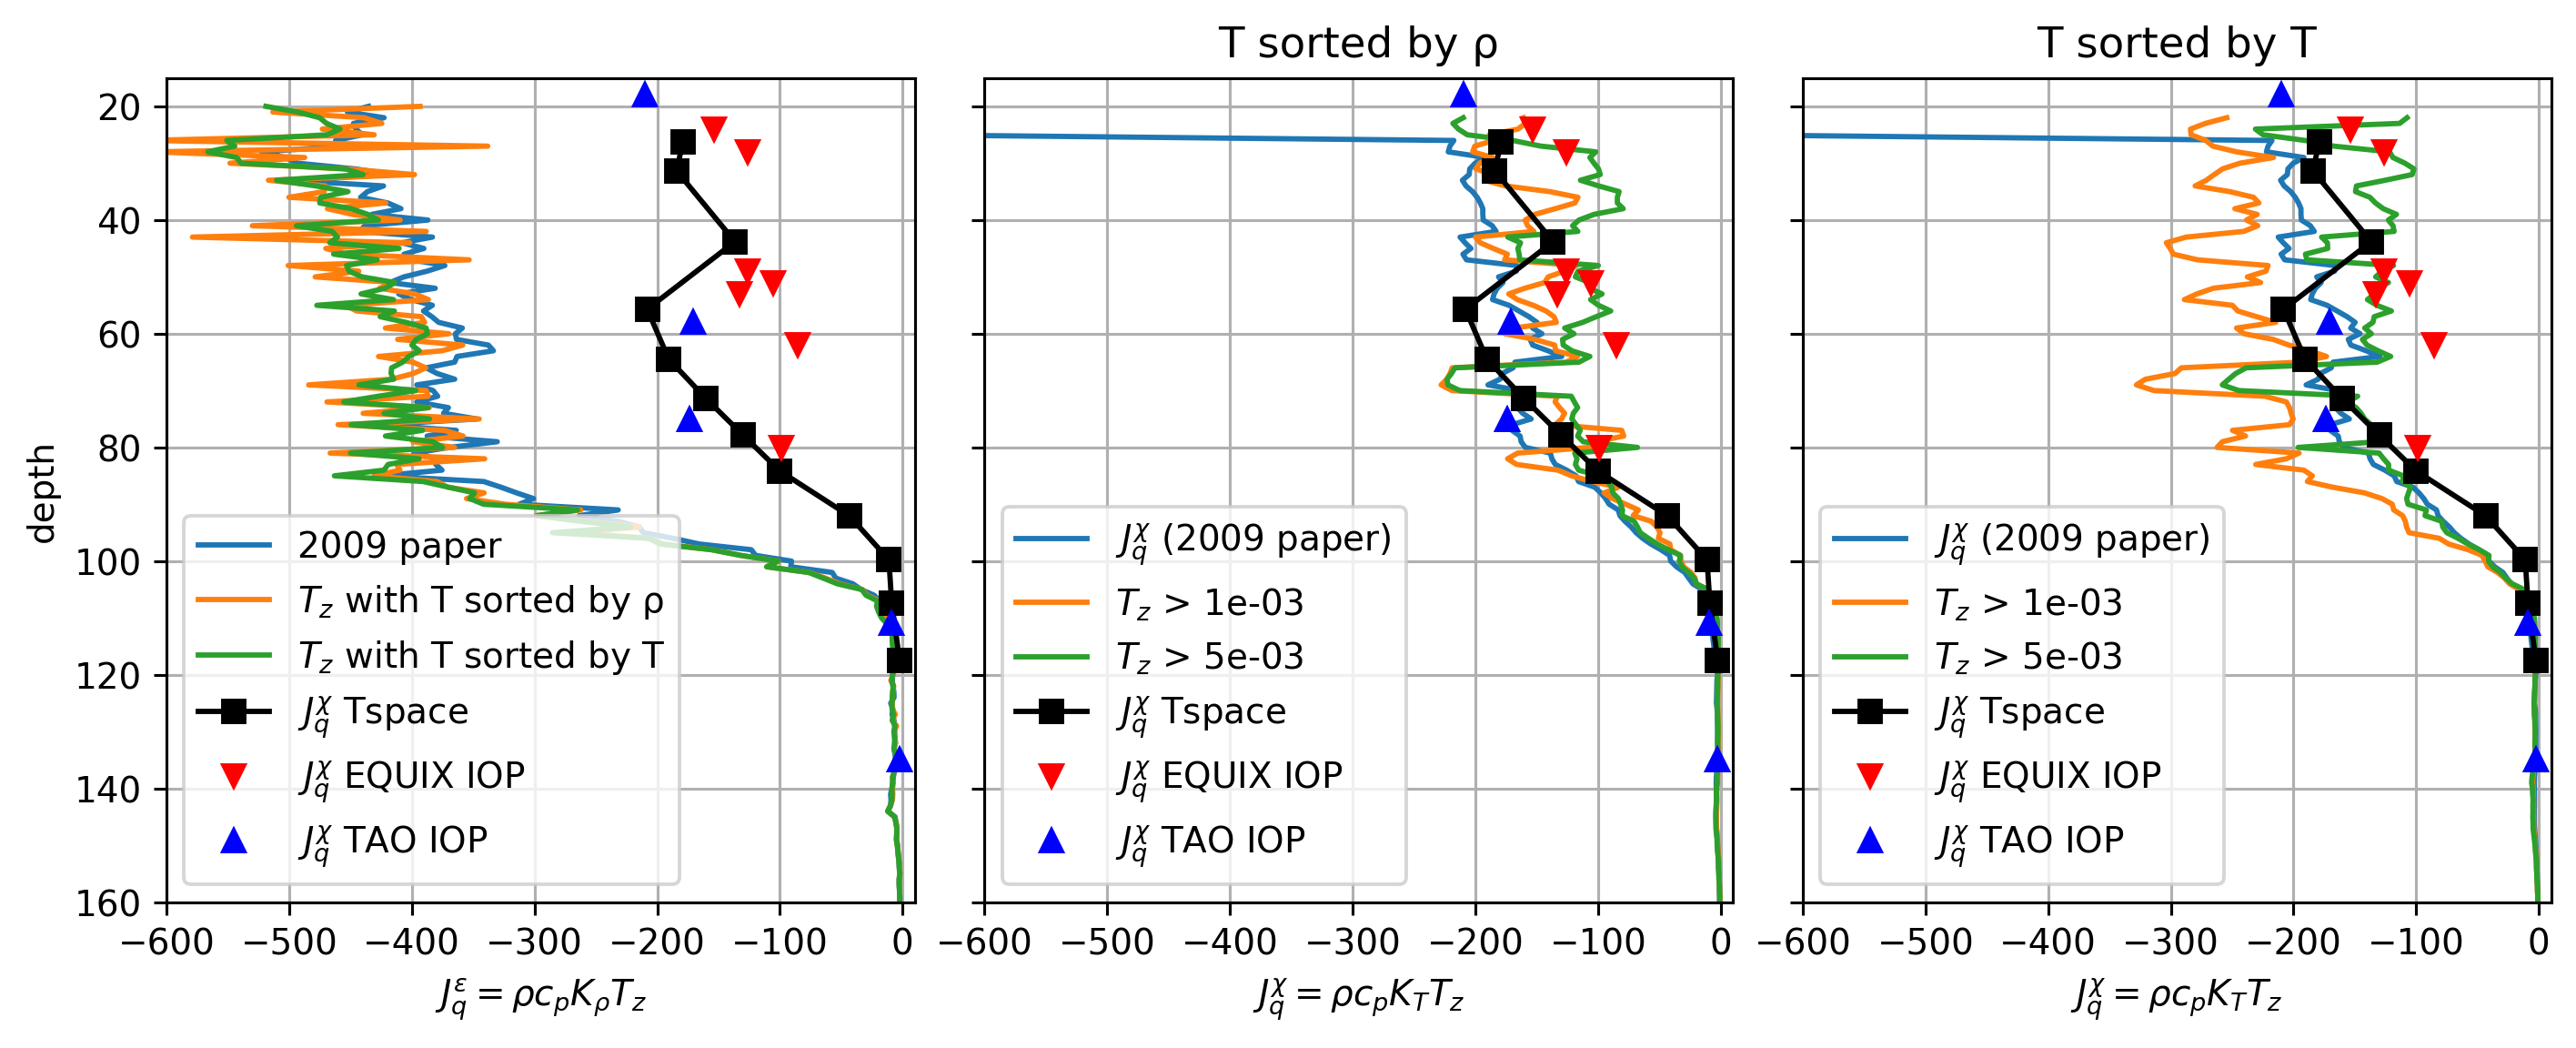

In [23]:
f, ax = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True)
f.set_size_inches((10, 4))

N2rho = 9.81 / 1025 * cham.pden.differentiate("depth")
N2sort = 9.81 / 1025 * thorpesort(cham.pden, cham.pden).differentiate("depth")
for cham_, label in zip(
    [cham, chamρ, chamT],
    ["2009 paper", "$T_z$ with T sorted by ρ", "$T_z$ with T sorted by T"],
):
    (1025 * 4000 * 0.2 * cham.eps / cham.N2.where(cham.N2 > 5e-6) * cham_.dTdz).mean(
        "time"
    ).plot(
        y="depth",
        yincrease=False,
        # color="k",
        label=label,
        ax=ax[0],
    )
ax[0].set_xlabel("$J_q^ε = ρ c_p K_ρ T_z$")


for cham_, axx in zip([chamρ, chamT], ax[1:]):
    Jq(cham, min_dTdz=1e-10).mean("time").plot(
        y="depth",
        yincrease=False,
        label="$J_q^χ$ (2009 paper)",
        ax=axx,
    )
    for min_dTdz in [1e-3, 5e-3]:
        Jq(cham_, min_dTdz=min_dTdz).mean("time").plot(
            y="depth",
            yincrease=False,
            label=f"$T_z$ > {min_dTdz:.0e}",
            ax=axx,
        )
    axx.set_xlabel("$J_q^χ = ρ c_p K_T T_z$")

for axx in ax:
    cham_Tmean.Jq.plot(
        y="z_c",
        marker="s",
        color="k",
        label="$J_q^χ$ Tspace",
        ax=axx,
        _labels=False,
    )
    (-1 * iop.Jq).mean("time").plot(
        y="depth",
        marker="v",
        ls="none",
        label="$J_q^χ$ EQUIX IOP",
        ax=axx,
        color="r",
        _labels=False,
    )
    (-1 * tao_iop.Jq).mean("time").plot(
        y="depth",
        marker="^",
        ls="none",
        label="$J_q^χ$ TAO IOP",
        ax=axx,
        color="b",
        _labels=False,
    )


ax[1].set_title("T sorted by ρ")
ax[2].set_title("T sorted by T")
# (4e6 * 0.2 * cham.eps / cham.N2.where(mask) * cham.dTdz).mean("time").plot(
#    y="depth", yincrease=False, ylim=[150, 20], xlim=[-1000, 1000]
# )

# (Jq(cham5m)).mean("time").plot(y="depth", yincrease=False)
# (4e6 * 0.2 * cham5m.eps / cham5m.N2.where(mask) * cham5m.dTdz).mean("time").plot(
#    y="depth", yincrease=False, ylim=[150, 20], xlim=[-1000, 1000]
# )

# cham5m.Jq_χ.mean("time").plot(y="depth", yincrease=False, color="k", ls="--")

plt.xlim(-600, 10)
plt.ylim(160, 15)
[ax.grid(True) for ax in ax]
[ax.legend() for ax in ax]
dcpy.plots.clean_axes(ax)
plt.savefig("../images/equix-jq-iop-cham-vs-chipod.png")

## Perlin & Moum: 

### χ, ε

Reproducing Perlin & Moum

1. 75m TAO ε is low

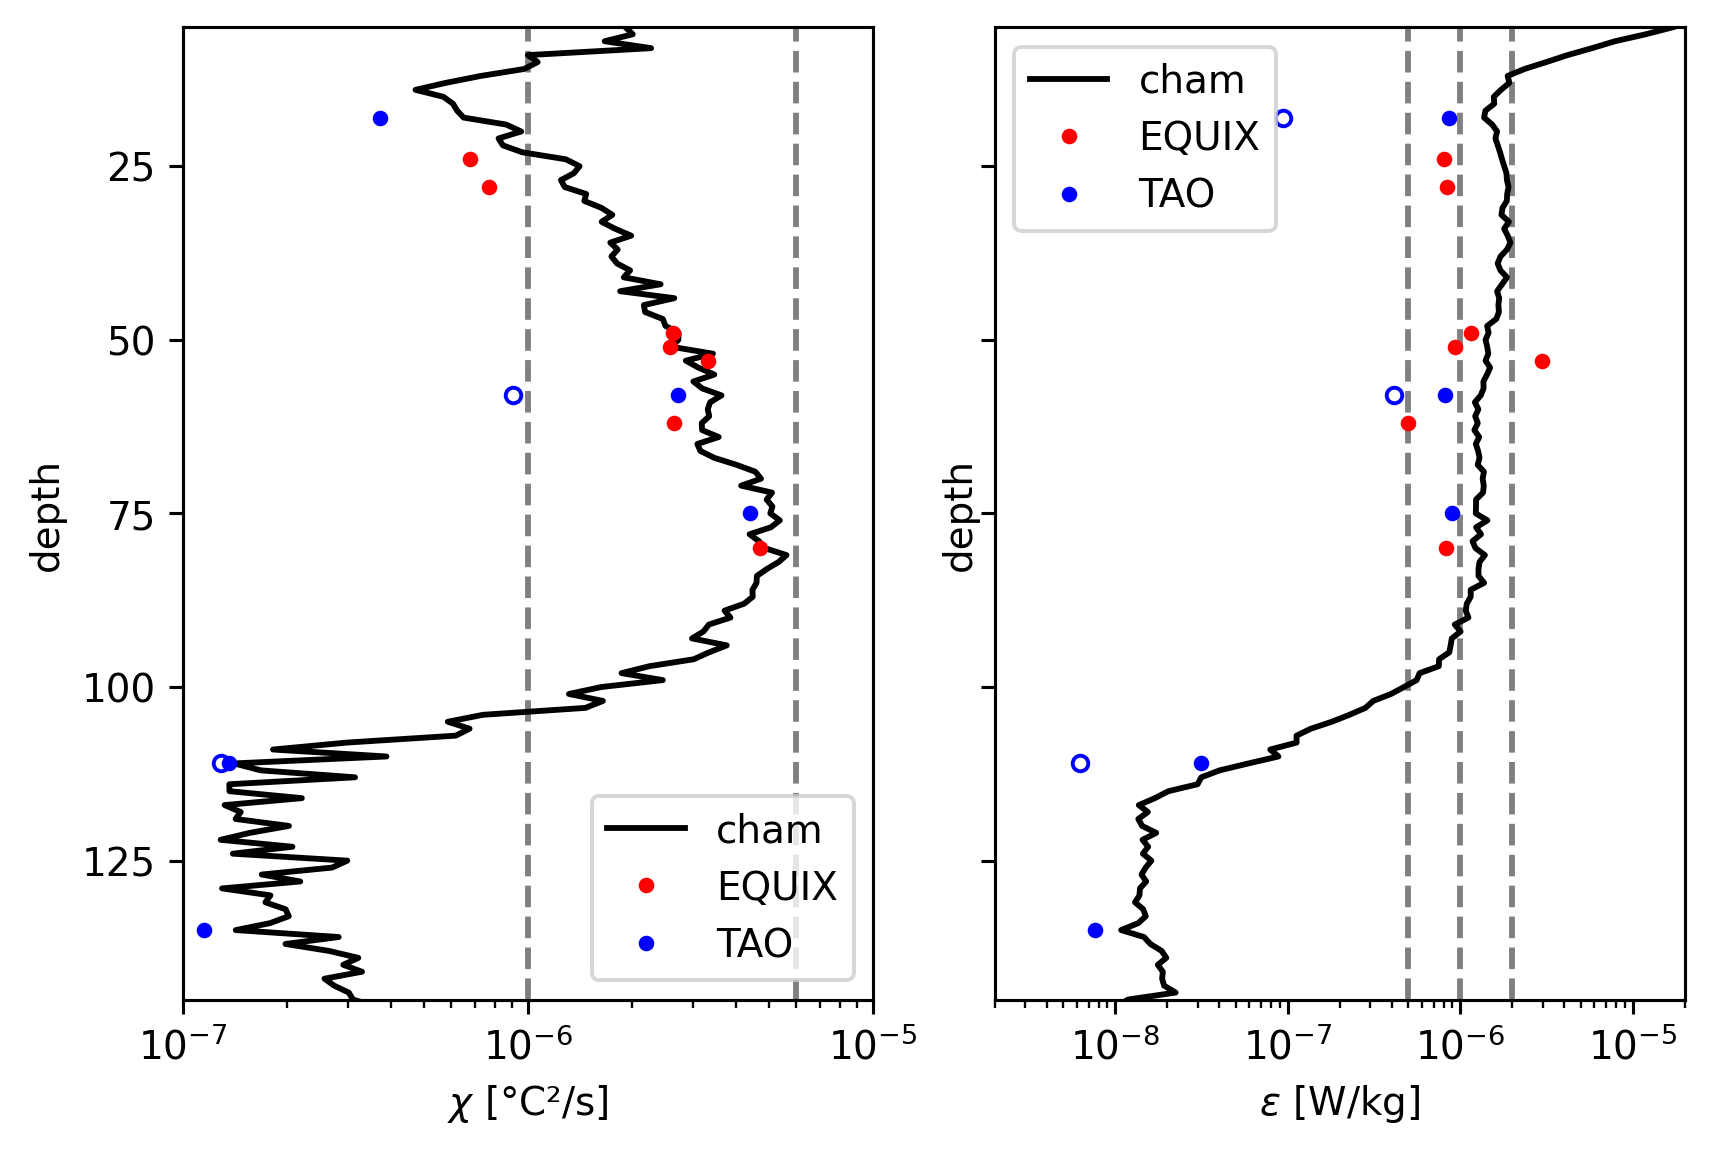

In [113]:
f, axx = plt.subplots(1, 2, sharey=True, constrained_layout=True)
ax = dict(zip(["chi", "eps"], axx))

for var in ax:
    cham[var].where(cham[var] < 1e-3).mean("time").cf.plot(
        xscale="log", color="k", ax=ax[var], label="cham"
    )
    iop[var].mean("time").cf.plot(
        marker=".", ls="none", label="EQUIX", color="r", ax=ax[var]
    )
    tao_iop[var + "1"].mean("time").cf.plot(
        marker=".", color="b", ls="none", label="TAO", ax=ax[var]
    )
    # iop[var + "2"].mean("time").cf.plot(marker=".", ls="none", label="IOP", color='r', ax=ax[var])
    ax[var].legend()
    tao_iop[var + "2"].mean("time").cf.plot(
        marker="o",
        markerfacecolor="none",
        ms=4,
        color="b",
        ls="none",
        label="TAO",
        ax=ax[var],
    )

ax["chi"].set_xlim([1e-7, 1e-5])
ax["chi"].set_ylim([145, 5])
ax["chi"].set_yticks([125, 100, 75, 50, 25])
dcpy.plots.linex([1e-6, 6e-6], ax=ax["chi"])

ax["eps"].set_xlim([2e-9, 2e-5])
dcpy.plots.linex([5e-7, 1e-6, 2e-6], ax=ax["eps"])

59m χpod sensor 2 is low, does not match Perlin & Moum.

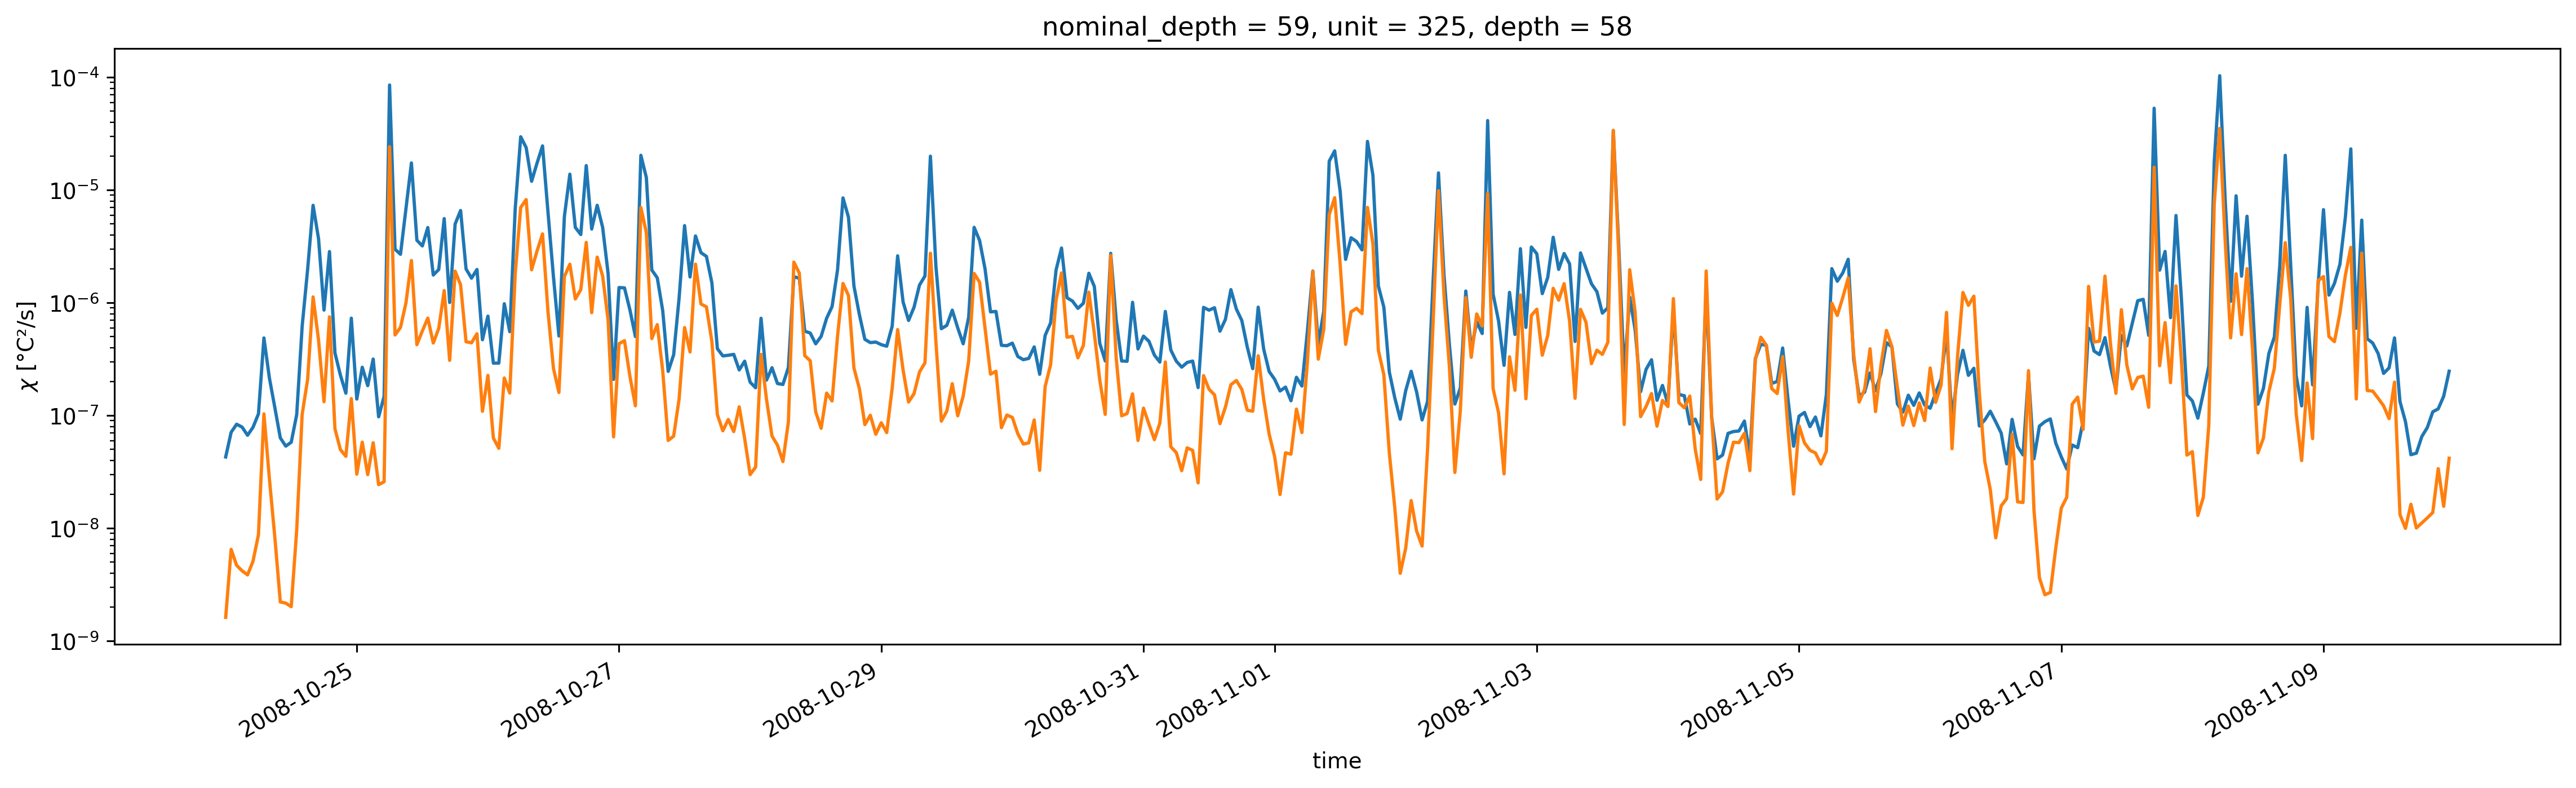

In [123]:
tao_iop.chi1.sel(depth=58).plot(size=5, aspect=4)
tao_iop.chi2.sel(depth=58).plot(yscale="log")

### Tz, N2

Text(0.5, 0, '$N^2$')

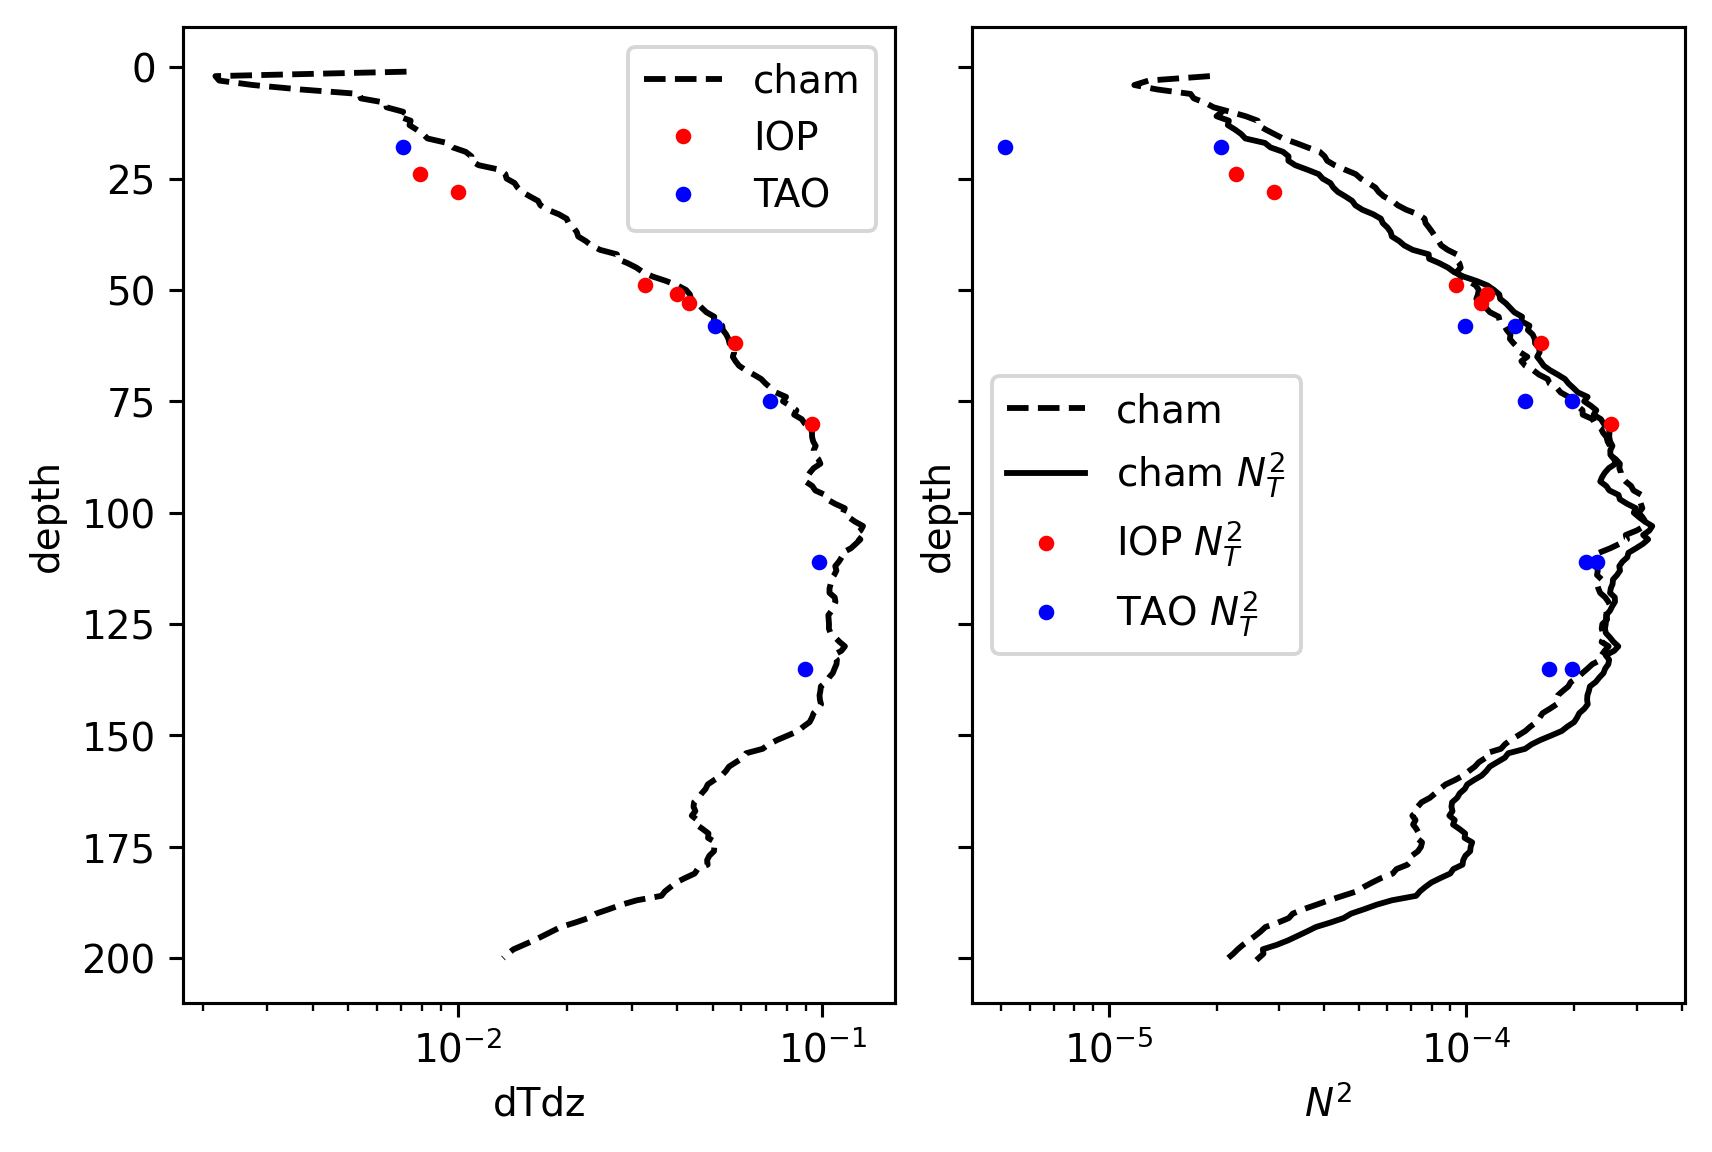

In [126]:
f, axx = plt.subplots(1, 2, sharey=True, constrained_layout=True)
ax = dict(zip(["dTdz", "N2"], axx))

for var in ax:
    np.abs(cham[var]).mean("time").cf.plot(ls="--", xscale="log", color='k', ax=ax[var], label="cham")
    if var != "N2":
        iop[var].mean("time").cf.plot(marker=".", ls="none", label="IOP", color='r', ax=ax[var])
        tao_iop[var].mean("time").cf.plot(marker='.', color='b', ls="none", label="TAO", ax=ax[var])
    if var == "N2":
        cham["NT2"].mean("time").cf.plot(ls="-", label="cham $N_T^2$", color='k', ax=ax[var])
        iop["NT2"].mean("time").cf.plot(marker=".", ls="none", label="IOP $N_T^2$", color='r', ax=ax[var])
        tao_iop["NT21"].mean("time").cf.plot(marker='.', color='b', ls="none", label="TAO $N_T^2$", ax=ax[var])
        tao_iop["NT22"].mean("time").cf.plot(marker='.', color='b', ls="none", ax=ax[var])
        
    ax[var].legend()
ax["N2"].set_xlabel("$N^2$")
#ax["dTdz"].set_xlim([7.5e-4, 2e-3])
#ax["N2"].set_xlim([7.5e-4, 2e-3]) 

## TIWE

In [ ]:
tiwe = xr.load_dataset("/home/deepak/datasets/microstructure/osu/tiwe.nc")
tiwe

In [ ]:
tiwe["Jq_ε"] = (
    1025
    * 4000
    * 0.2
    * tiwe.eps.where(tiwe.eps < 1e-5)
    / tiwe.N2.where(tiwe.N2 > 1e-6)
    * tiwe.dTdz.where(tiwe.dTdz > 1e-4)
)
tiwe["Jq_χ"] = (
    1025
    * 4000
    * tiwe.chi.where(tiwe.eps < 1e-5)
    / 2
    / tiwe.dTdz.where(np.abs(tiwe.sortT.diff("depth")) > 1e-3)
)

tiwe.Jq.sel(depth=slice(11, None)).mean("time").cf.plot(y="depth")
tiwe.Jq_ε.mean("time").cf.plot(y="depth")
tiwe.Jq_χ.mean("time").cf.plot(
    y="depth", yincrease=False, xscale="linear", xlim=(0, 120), ylim=(200, 0)
)

## Reproducing Perlin & Moum (2012)

I'm tuning max allowable χ, ε to visually match Perlin & Moum
1. Deepest 2 TAO χpods seem to be at wrong depths
2. TAO at 18m, 75m is too low.
3. ~Need to save both sensors separately. If I did average then that's an issue here.~ I did not average, just followed the comment and always picked sensor 1.

TODO:
1. Find all other sensor 2 data for EQUIX.
1. See if I can find Sasha's merged files

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True)

for axx, var in zip(ax.flat, ["chi", "eps"]):
    cham[var].where((cham.chi < 1e-2) & (cham.eps < 6e-5)).mean("time").cf.plot(
        xscale="log", xlim=(1e-7, 1e-5), ylim=(140, 10), color="k", ax=axx
    )
    iop[var].mean("time").plot(
        y="depth", marker=".", color="r", ls="none", ms=8, ax=axx
    )
    tao_iop[var].mean("time").plot(
        y="depth", marker=".", color="b", ls="none", ms=8, ax=axx
    )
    tao_iop[var + "2"].mean("time").plot(
        y="depth", marker="o", color="b", ls="none", ms=8, ax=axx, fillstyle="none"
    )


ax[0].set_yticks([25, 50, 75, 100, 125])
dcpy.plots.liney(25, ax=ax[0])
dcpy.plots.linex([1e-6, 5e-6], ax=ax[0])
dcpy.plots.linex([5e-7, 1e-6, 2e-6], ax=ax[1])

## Explorations

In [ ]:
cham5m = cham.copy(deep=True)
cham5m["dTdz"] = cham5m.sortT.differentiate("depth")
# cham5m["dTdz"] = cham5m.theta.diff("depth")# / cham5m.depth.diff("depth")
# cham5m["dTdz"] = cham5m.dTdz.where(np.abs(cham5m.dTdz) > 5e-3)
cham5m["N2"] = 9.81 / 1025 * cham5m.pden.differentiate("depth")

cham5m = cham5m.where((cham5m.N2 > 5e-6) & (np.abs(cham5m.dTdz) > 1e-3))
# cham5m["N2"] = np.abs(cham5m.N2.where(cham5m.N2 > 5e-6))

cham5m["KT"] = (
    cham5m.chi / 2 / cham5m.dTdz ** 2
)  # .where(np.abs(cham5m.dTdz) > 1e-3) ** 2
cham5m.KT.attrs = {"long_name": "$K_T$", "units": "m²/s"}
cham5m["Kρ"] = 0.2 * cham5m.eps / cham5m.N2
cham5m.Kρ.attrs = {"long_name": "$K_ρ$", "units": "m²/s"}
cham5m.chi.where(cham5m.chi < 1e-3)

cham5m["Jq_χ"] = 1025 * 4000 * cham5m.KT * cham5m.dTdz
cham5m.Jq_χ.attrs = {"long_name": "$J_q^χ$", "units": "W/m²"}
cham5m["Jq_ε"] = 1025 * 4000 * cham5m.Kρ * cham5m.dTdz
cham5m.Jq_ε.attrs = {"long_name": "$J_q^ε$", "units": "W/m²"}

In [ ]:
cham5m.KT.plot.hist(
    bins=np.logspace(-7, -1, 35),
    xscale="log",
    histtype="step",
    density=True,
    label="$K_T$",
)
cham5m.Kρ.plot.hist(
    bins=np.logspace(-7, -1, 35),
    histtype="step",
    xscale="log",
    density=True,
    label="$K_ρ$",
)
plt.legend()

In [ ]:
(4e6 * cham5m.KT * cham5m.dTdz).plot.hist(
    yscale="log", bins=np.linspace(-1500, 1500, 100), histtype="step", label="$J_q^χ$"
)
(4e6 * cham5m.Kρ * cham5m.dTdz).plot.hist(
    yscale="log", bins=np.linspace(-1500, 1500, 100), histtype="step", label="$J_q^ε$"
)
plt.legend()

In [ ]:
f, axx = plt.subplots(1, 2, sharey=True, constrained_layout=True)

cham5m.KT.mean("time").cf.plot(ax=axx[0], label="$K_T$")
cham5m.Kρ.mean("time").cf.plot(xscale="log", ax=axx[0], label="$K_ρ$")

cham5m.Jq_χ.where(cham5m.dTdz < 0).mean("time").cf.plot(ax=axx[1], label="$J_q^χ$")
cham5m.Jq_ε.where(cham5m.dTdz < 0).mean("time").cf.plot(
    xlim=(-700, 0), ax=axx[1], label="$J_q^ε$"
)

[ax.legend() for ax in axx.flat]